In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

df = pd.read_csv("effectifs.csv", sep=";")

## 1. Nettoyage des données

In [14]:
# Suppression des lignes où Ntop est manquant (variable cible)
df = df.dropna(subset=["Ntop"])

# Suppression des lignes région 99 (France entière — biais pour l'analyse régionale)
df.drop(df[df["region"] == 99].index, inplace=True)

print("Shape après nettoyage :", df.shape)
print("Valeurs manquantes sur Ntop :", df["Ntop"].isnull().sum())
print("Régions présentes :", sorted(df["region"].unique()))

Shape après nettoyage : (3792196, 16)
Valeurs manquantes sur Ntop : 0
Régions présentes : [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(11), np.int64(24), np.int64(27), np.int64(28), np.int64(32), np.int64(44), np.int64(52), np.int64(53), np.int64(75), np.int64(76), np.int64(84), np.int64(93), np.int64(94)]


## 2. Agrégation et recalcul de la prévalence

On agrège les données par `(annee, region, patho_niv1)` pour se placer au bon niveau d'analyse.

La prévalence est recalculée **après nettoyage** avec la formule :

> `prevalence = ΣNtop / ΣNpop`

**Pourquoi ne pas utiliser `prev` originale ?**
- Calculée à un niveau trop fin (département + âge + sexe)
- Non comparable entre régions
- 1 382 435 valeurs NaN

Notre prévalence recalculée est au niveau région → fiable et comparable. 

In [15]:
# Agrégation par annee, region, patho_niv1
df_model = (
    df.groupby(["annee", "region", "patho_niv1"])
    .agg({"Ntop": "sum", "Npop": "sum"})
    .reset_index()
)

# Recalcul prévalence sur données propres
df_model["prevalence"] = df_model["Ntop"] / df_model["Npop"]

print("Shape df_model :", df_model.shape)
print("NaN dans prevalence :", df_model["prevalence"].isnull().sum())
df_model.head()

Shape df_model : (2826, 6)
NaN dans prevalence : 0


,annee,region,patho_niv1,Ntop,Npop,prevalence
0,2015,1,Affections de longue durée (dont 31 et 32) pou...,110620.0,3008400,0.036770
1,2015,1,Cancers,355180.0,30751080,0.011550
2,2015,1,Diabète,300900.0,2897560,0.103846
3,2015,1,Hospitalisations hors pathologies repérées (av...,388280.0,3008400,0.129065
4,2015,1,Insuffisance rénale chronique terminale,14900.0,7969480,0.001870


## 3. Transformation logarithmique de la variable cible

L'EDA a mesuré une skewness de **≈ 252** sur `Ntop` → distribution très asymétrique à droite.

**Action** : `log1p(Ntop)` pour corriger cette asymétrie avant la modélisation.

- `log1p(x) = log(1 + x)` → fonctionne même sur les valeurs nulles
- Réduit l'impact des outliers (grandes régions très peuplées)
- Stabilise les prédictions du modèle

On compare la distribution avant et après transformation.

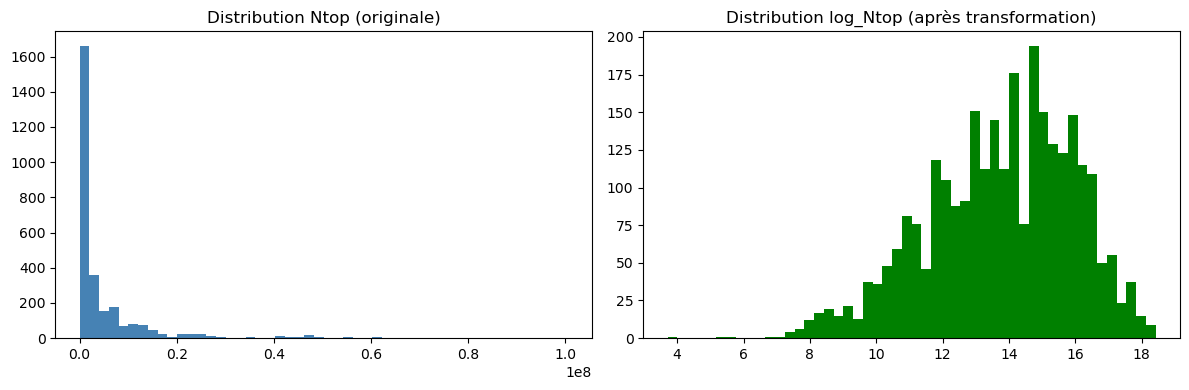

Skewness avant : 4.43
Skewness après : -0.47


In [16]:
df_model["log_Ntop"] = np.log1p(df_model["Ntop"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_model["Ntop"], bins=50, color='steelblue')
axes[0].set_title("Distribution Ntop (originale)")

axes[1].hist(df_model["log_Ntop"], bins=50, color='green')
axes[1].set_title("Distribution log_Ntop (après transformation)")

plt.tight_layout()
plt.show()

print(f"Skewness avant : {df_model['Ntop'].skew():.2f}")
print(f"Skewness après : {df_model['log_Ntop'].skew():.2f}")

## 5. Définition des features, split train/test et normalisation

**Features retenues** : `annee`, `patho_niv1_enc`, `region_enc`

**Variable cible** : `log_Ntop`

**Variables exclues** :
- `prev` originale : trop de NaN, niveau trop fin
- `Npop` : data leakage potentiel (taille population connue à l'avance)
- `prevalence` : calculée à partir de `Ntop` → data leakage direct

**Split 80/20** : 80% pour entraîner, 20% pour évaluer sans biais

**StandardScaler** : centre et réduit les variables (moyenne=0, écart-type=1) — bonne pratique même pour les modèles ensemblistes

In [17]:
from sklearn.model_selection import train_test_split

features = ["annee", "patho_niv1", "region"]
target = "log_Ntop"

X = df_model[features]
y = df_model[target]

X_pathologies_train, X_pathologies_test, y_pathologies_train, y_pathologies_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_pathologies_train :", X_pathologies_train.shape)
print("X_pathologies_test :", X_pathologies_test.shape)

X_pathologies_train : (2260, 3)
X_pathologies_test : (566, 3)


In [18]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

numeric_features = ["annee"]
categorical_features = ["region", "patho_niv1"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

In [19]:
print(rf_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['annee']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['region', 'patho_niv1'])])),
               

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

lin_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lin_pipeline.fit(X_pathologies_train, y_pathologies_train)

y_pathologies_pred_lin = lin_pipeline.predict(X_pathologies_test)

rmse_lin = np.sqrt(mean_squared_error(y_pathologies_test, y_pathologies_pred_lin))
r2_lin = r2_score(y_pathologies_test, y_pathologies_pred_lin)

print("Linear Regression")
print("RMSE:", rmse_lin)
print("R2:", r2_lin)

joblib.dump(lin_pipeline, "../model/linear.pkl")


Linear Regression
RMSE: 1.9724720758050072
R2: 0.15629798088844227


['../model/linear.pkl']

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

rf_pipeline.fit(X_pathologies_train, y_pathologies_train)

y_pathologies_pred_rf = rf_pipeline.predict(X_pathologies_test)

rmse_rf = np.sqrt(mean_squared_error(y_pathologies_test, y_pathologies_pred_rf))
r2_rf = r2_score(y_pathologies_test, y_pathologies_pred_rf)

print("Random Forest")
print("RMSE:", rmse_rf)
print("R2:", r2_rf)

joblib.dump(rf_pipeline, "../model/random_forest.pkl")

Random Forest
RMSE: 0.28567187006398037
R2: 0.9823028913703654


['../model/random_forest.pkl']

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_pipeline.fit(X_pathologies_train, y_pathologies_train)

y_pathologies_pred_gb = gb_pipeline.predict(X_pathologies_test)

rmse_gb = np.sqrt(mean_squared_error(y_pathologies_test, y_pathologies_pred_gb))
r2_gb = r2_score(y_pathologies_test, y_pathologies_pred_gb)

print("Gradient Boosting")
print("RMSE:", rmse_gb)
print("R2:", r2_gb)

joblib.dump(gb_pipeline, "../model/gradient_boosting.pkl")

Gradient Boosting
RMSE: 0.35914581052270395
R2: 0.9720289370546081


['../model/gradient_boosting.pkl']

In [23]:
# ===============================
# TEST DE DATA LEAKAGE
# ===============================

import numpy as np
from sklearn.metrics import r2_score

# On mélange complètement la target d'entraînement
y_train_shuffled = np.random.permutation(y_train)

# On réentraîne le pipeline avec la target mélangée
rf_pipeline.fit(X_train, y_train_shuffled)

# On évalue sur le vrai test
y_pred_shuffled = y_pred_shuffled = rf_pipeline.predict(X_test)

r2_leak_test = r2_score(y_test, y_pred_shuffled)

print("R2 avec target mélangée :", r2_leak_test)

R2 avec target mélangée : -0.28540188532511945
